# Introduction
This Jupiter Notebook implements a machine learning algorithm to detect sign language with a sensor glove. The glove uses 6 flex sensors, one for each finger and one for the wrist. Additionally, an IMU is placed on the top of the wrist.
For the sign language signal processing and classification, we utilize the capabilities of a **Convolutional Neural Network (CNN) Autoencoder**.

Our primary objective is to construct a robust Autoencoder model tailored for the task of detecting sign language.

## Dataset Overview

  The data is generated with the sensor glove connected to an ESP32 and an Arduino code implementing a fixed data collection for a specified time of 1.5 seconds for each sign. The data is collected in following order: XAcc,YAcc,ZAcc,XGyro,YGyro,ZGyro,Thumb,Index,Middle,Ring,Pinkie,Wrist, Wheras the finger and wrist data has to be calibrated before data generation.
  The dataset is sampled at 100Hz, providing high-resolution data for in-depth analysis.

 The generated sign lanuge data set consists of five signs of Austrian Sign Language (österreichische Gebärdensprache): Bitte, Danke, Ich, Hallo und Baba. We categorized them into five classes with the same name.

  We used a randomized order to collect data to ensure a variable and not prejudiced data generation. Therefore we generated a variable order of 10 signs out of the signs Bitte, Danke, Ich, Hallo, Tschüss.
  The Arduino code generated the raw data where every 1.5 seconds is an empty line in between each singn. Then we copied the raw data out of the serial monitor in a text file.
  
  Afterwards, we separated each sign into corresponding text files named using the format SignName_Initial_Number (for example: hallo_m_1 for the first file with "Hallo" from Martina). To ensure the same data length for each file, we decided to cut the files at 37 lines. If a file had 38 lines, the last line was deleted to maintain uniformity of the data.

> Some essential details about the Database:
>
> - **Number of Samples:** X
> - **Number of Categories:** 5
> - **Sampling Frequency:** 100Hz

import relevant librarys

In [12]:
import numpy as np
np.set_printoptions(suppress=True)
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import arff
from sklearn.model_selection import train_test_split
import matplotlib
matplotlib.rcParams["figure.figsize"] = (6, 4)
plt.style.use("ggplot")
import tensorflow as tf
from tensorflow import data
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import mae
from tensorflow.keras import layers
from tensorflow import keras
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix, f1_score, classification_report
import os
import glob
import random


In [2]:
# generate accesss to the drive (=data) there are all the labelled csv. files stored
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Change to the directory where your text files are located
os.chdir('/content/drive/MyDrive/Advanced Data analysis and artificial intelligence/Project/data/Data seperated Martina')

In [6]:
# List files in the directory to verify
file_list = os.listdir()
print(file_list)

# Display the class names (folders)
for file_name in file_list:
    if file_name.endswith('.txt'):  # Check if it is a text file
        with open(file_name, 'r') as file:
            content = file.read()

['Baba', 'Danke', 'Ich', 'Hallo', 'Bitte']


get access to text files in subfolders

In [9]:

# Function to read all text files in nested directories
def read_text_files_in_nested_directories(base_path):
    data = {}
    # Iterate over each subdirectory in the base path
    for subdir in os.listdir(base_path):
        subdir_path = os.path.join(base_path, subdir)
        if os.path.isdir(subdir_path):
            # Initialize a list to store contents of files in the subdirectory
            data[subdir] = []
            # Get all text files in the current subdirectory
            text_files = glob.glob(os.path.join(subdir_path, '*.txt'))
            for text_file in text_files:
                with open(text_file, 'r') as file:
                    content = file.read()
                    data[subdir].append(content)
    return data

# Base path to your main folder containing subfolders
base_path = '/content/drive/MyDrive/Advanced Data analysis and artificial intelligence/Project/data/Data seperated Martina'
data = read_text_files_in_nested_directories(base_path)


# display shape of data
to see how much data is in each folder and if the line number of 37 is correct

In [11]:
#function to count text files in folder
def count_text_files_in_folder(folder_path):
    file_count = sum(1 for file in os.listdir(folder_path) if file.endswith('.txt'))
    return file_count

# function to count lines in text files
def count_lines_in_text_files(folder_path):
    file_line_counts = {}
    for filename in os.listdir(folder_path):
        if filename.endswith('.txt'):
            file_path = os.path.join(folder_path, filename)
            with open(file_path, 'r') as file:
                lines = file.readlines()
                line_count = len(lines)
                file_line_counts[filename] = line_count
    return file_line_counts

# names of subfolders
subfolders = ["Bitte", "Baba", "Danke", "Hallo", "Ich"]

# Zähle die Anzahl der Textdateien und die Anzahl der Zeilen in jedem Unterordner
for folder_name in subfolders:
    folder_path = os.path.join(base_path, folder_name)
    file_count = count_text_files_in_folder(folder_path)
    line_count = count_lines_in_text_files(folder_path)
    print(f"Folder '{folder_name}': Numer of text files: {file_count}, number of lines: {line_count}")

Folder 'Bitte': Numer of text files: 24, number of lines: {'bitte_m_1.txt': 37, 'bitte_m_2.txt': 37, 'bitte_m_3.txt': 37, 'bitte_m_4.txt': 37, 'bitte_m_5.txt': 37, 'bitte_m_6.txt': 37, 'bitte_m_7.txt': 37, 'bitte_m_8.txt': 37, 'bitte_m_9.txt': 37, 'bitte_m_10.txt': 37, 'bitte_m_11.txt': 37, 'bitte_m_12.txt': 37, 'bitte_m_13.txt': 37, 'bitte_m_14.txt': 37, 'bitte_m_15.txt': 37, 'bitte_m_16.txt': 37, 'bitte_m_17.txt': 37, 'bitte_m_18.txt': 37, 'bitte_m_19.txt': 37, 'bitte_m_20.txt': 37, 'bitte_m_21.txt': 37, 'bitte_m_22.txt': 37, 'bitte_m_23.txt': 37, 'bitte_m_24.txt': 37}
Folder 'Baba': Numer of text files: 21, number of lines: {'baba_m_1.txt': 37, 'baba_m_2.txt': 37, 'baba_m_3.txt': 37, 'baba_m_4.txt': 37, 'baba_m_5.txt': 37, 'baba_m_6.txt': 37, 'baba_m_7.txt': 37, 'baba_m_8.txt': 37, 'baba_m_9.txt': 37, 'baba_m_10.txt': 37, 'baba_m_11.txt': 37, 'baba_m_12.txt': 37, 'baba_m_13.txt': 37, 'baba_m_14.txt': 37, 'baba_m_15.txt': 37, 'baba_m_16.txt': 37, 'baba_m_17.txt': 37, 'baba_m_18.txt':

The code below generates a visual comparison between two randomly selected datasets for a sign. This side-by-side plot enables a direct visual assessment of signal patterns between the different signs.
**insert plot from Julia**

make one total dataframe and assign labels and classnames


In [31]:
# load data from text files and label them and assign classnames
def load_and_label_data(folder_path, class_label, class_name):
    data_list = []
    for filename in os.listdir(folder_path):
        if filename.endswith('.txt'):
            file_path = os.path.join(folder_path, filename)
            df = pd.read_csv(file_path, sep=',', header=None)  # data is seperated trough , and without header
            df['Label'] = class_label
            df['ClassName'] = class_name
            data_list.append(df)
    return data_list

bitte_path = os.path.join(base_path, "Bitte")
hallo_path = os.path.join(base_path, "Hallo")
baba_path = os.path.join(base_path, "Baba")
danke_path = os.path.join(base_path, "Danke")
ich_path = os.path.join(base_path, "Ich")

bitte_data = load_and_label_data(bitte_path, class_label=0, class_name="Bitte")
hallo_data = load_and_label_data(hallo_path, class_label=1, class_name="Hallo")
baba_data = load_and_label_data(baba_path, class_label=2, class_name="Baba")
danke_data = load_and_label_data(danke_path, class_label=3, class_name="Danke")
ich_data = load_and_label_data(ich_path, class_label=4, class_name="Ich")

# combine all data in one list
combined_data = bitte_data + hallo_data + baba_data + danke_data + ich_data

# combine list in dataframe
combined_df = pd.concat(combined_data, ignore_index=True)

# check dimension of dataframe
print(combined_df.shape)

# adjust Pandas-display oprions to show all collumns benath each other
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.width', 2000)

# choose 5 random dataset out of the combined data list and check them
random_data_samples = random.sample(combined_data, 5)
for i, df in enumerate(random_data_samples):
    print(f"DataFrame {i+1}:")
    print(df.head())
    print(df.shape)

(3700, 14)
DataFrame 1:
      0     1     2     3     4     5    6    7    8    9   10    11  Label ClassName
0  3.64  8.00 -0.49 -0.21  0.32  1.15  921  806  902  892  854  1066      3     Danke
1  3.09  8.11  1.58 -0.03  0.61  1.57  953  831  910  895  870  1074      3     Danke
2  4.22  7.54  1.70  0.83  1.71  2.19  921  840  912  893  847  1077      3     Danke
3  5.09  8.51  3.08  1.06  3.22  3.59  843  798  890  852  885  1077      3     Danke
4  7.93  8.06  1.92  1.66  4.87  3.15  921  815  894  852  847  1072      3     Danke
(37, 14)
DataFrame 2:
       0     1     2     3     4     5    6    7    8    9   10    11  Label ClassName
0  11.77  1.60  2.47  0.25  2.06  0.74  859  647  848  642  740  1176      0     Bitte
1  14.89  0.77  2.46 -0.77  2.67 -0.27  828  672  891  677  770  1181      0     Bitte
2  11.86  2.54  3.55 -0.51  0.88 -0.31  781  731  914  703  755  1186      0     Bitte
3  14.78  1.95  4.65  0.06 -0.26 -0.46  781  764  939  752  770  1189      0     Bitte
4  

**explanation of the lines above**
The total dataframe consists 100 signs recorded.
Each text file consists of 37 timesteps.
Each row (timestep) has 14 columns containing the following data:
12 measurements (XAcc,YAcc,ZAcc,XGyro,YGyro,ZGyro,Thumb,Index,Middle,Ring,Pinkie,Wrist), 1 label column (Label),1 class name column (ClassName), which relusts in a matrix: (37,14).

## normalize that data to get same amount of data for each sign
 count the number of text files in each folder and find the minimum count. Then, resize the datasets accordingly.

In [35]:

# Function to resize datasets to the same size
def resize_data(data_list, min_size):
    resized_data = [df[:min_size] for df in data_list]
    return resized_data

# Determine the minimum number of text files in a folder
def min_files_in_folder(folder_paths):
    min_count = float('inf')
    for folder_path in folder_paths:
        file_count = len([f for f in os.listdir(folder_path) if f.endswith('.txt')])
        if file_count < min_count:
            min_count = file_count
    return min_count

# Determine the minimum number of text files among all folders
min_files = min_files_in_folder([bitte_path, hallo_path, baba_path, danke_path, ich_path])

# Resize datasets to match the size of the dataset with the least amount of data
resized_data = [resize_data(data, min_files) for data in [bitte_data, hallo_data, baba_data, danke_data, ich_data]]

# Concatenate resized datasets into a single DataFrame
combined_df = pd.concat([pd.concat(data, ignore_index=True) for data in resized_data], ignore_index=True)

for folder_name in subfolders:
  print(f"Folder '{folder_name}': Numer of text files: {min_files}, number of lines: {line_count}")

Folder 'Bitte': Numer of text files: 17, number of lines: {'ich_m_1.txt': 37, 'ich_m_2.txt': 37, 'ich_m_3.txt': 37, 'ich_m_4.txt': 37, 'ich_m_5.txt': 37, 'ich_m_6.txt': 37, 'ich_m_7.txt': 37, 'ich_m_8.txt': 37, 'ich_m_9.txt': 37, 'ich_m_10.txt': 37, 'ich_m_11.txt': 37, 'ich_m_12.txt': 37, 'ich_m_13.txt': 37, 'ich_m_14.txt': 37, 'ich_m_15.txt': 37, 'ich_m_16.txt': 37, 'ich_m_17.txt': 37, 'ich_m_18.txt': 37, 'ich_m_19.txt': 37, 'ich_m_20.txt': 37}
Folder 'Baba': Numer of text files: 17, number of lines: {'ich_m_1.txt': 37, 'ich_m_2.txt': 37, 'ich_m_3.txt': 37, 'ich_m_4.txt': 37, 'ich_m_5.txt': 37, 'ich_m_6.txt': 37, 'ich_m_7.txt': 37, 'ich_m_8.txt': 37, 'ich_m_9.txt': 37, 'ich_m_10.txt': 37, 'ich_m_11.txt': 37, 'ich_m_12.txt': 37, 'ich_m_13.txt': 37, 'ich_m_14.txt': 37, 'ich_m_15.txt': 37, 'ich_m_16.txt': 37, 'ich_m_17.txt': 37, 'ich_m_18.txt': 37, 'ich_m_19.txt': 37, 'ich_m_20.txt': 37}
Folder 'Danke': Numer of text files: 17, number of lines: {'ich_m_1.txt': 37, 'ich_m_2.txt': 37, 'ich

## Splitting the data to training and testing set

In [37]:
# Perform train-test split with a ratio of 90% for training and 10% for testing
X = combined_df.drop(['Label', 'ClassName'], axis=1)
y = combined_df['Label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Display the shapes of train and test sets
print("Train set shape:", X_train.shape, len(y_train))
print("Test set shape:", X_test.shape, len(y_test))

Train set shape: (1530, 12) 1530
Test set shape: (170, 12) 170


# Building CNN Autoencoder Model

## About Autoencoders: Learning Efficient Data Representations

Autoencoders are a class of neural network architectures commonly used in unsupervised machine learning and deep learning tasks. Their primary purpose is to discover and learn efficient representations of data by encoding it into a lower-dimensional latent space and subsequently decoding it back to its original form. Autoencoders play a crucial role in various applications, such as dimensionality reduction, data denoising, anomaly detection, and generative modeling.

The core components of an autoencoder consist of an encoder and a decoder. The encoder maps input data to the latent space, while the decoder reconstructs the data from its encoded representation. During training, autoencoders aim to minimize the reconstruction error between the input and the decoded output, which results in the learning of meaningful data representations.

Autoencoders offer a versatile tool for feature extraction, data compression, and more, making them a valuable addition to the toolkit of data scientists and machine learning practitioners.


![Autoencoder](https://miro.medium.com/v2/resize:fit:640/format:webp/1*nqzWupxC60iAH2dYrFT78Q.png)

In [49]:
tf.keras.utils.set_random_seed(1024)

In [50]:
class AutoEncoder(tf.keras.Model):
    def __init__(self, input_dim, latent_dim):
        super(AutoEncoder, self).__init__()
        self.input_dim = input_dim
        self.latent_dim = latent_dim

        # Encoder part
        self.encoder = tf.keras.Sequential([
            layers.Input(shape=(input_dim,)),
            layers.Reshape((input_dim, 1)),
            layers.Conv1D(128, 3, strides=1, activation='relu', padding="same"),
            layers.BatchNormalization(),
            layers.MaxPooling1D(2, padding="same"),
            layers.Conv1D(128, 3, strides=1, activation='relu', padding="same"),
            layers.BatchNormalization(),
            layers.MaxPooling1D(2, padding="same"),
            layers.Conv1D(latent_dim, 3, strides=1, activation='relu', padding="same"),
            layers.BatchNormalization(),
            layers.MaxPooling1D(2, padding="same"),
        ])

        # Decoder part
        self.decoder = tf.keras.Sequential([
            layers.Conv1DTranspose(latent_dim, 3, strides=1, activation='relu', padding="same"),
            layers.BatchNormalization(),
            layers.Conv1DTranspose(128, 3, strides=1, activation='relu', padding="same"),
            layers.BatchNormalization(),
            layers.Conv1DTranspose(128, 3, strides=1, activation='relu', padding="same"),
            layers.BatchNormalization(),
            layers.Flatten(),
            layers.Dense(input_dim)
        ])

    def call(self, X):
        encoded = self.encoder(X)
        decoded = self.decoder(encoded)
        return decoded

# Beispiel zur Verwendung des Autoencoders
input_dim = 12  # Beispielwert für die Eingabedimension
latent_dim = 16  # Beispielwert für die Dimension der latenten Variablen

# Erzeuge eine Instanz des Autoencoders
autoencoder = AutoEncoder(input_dim, latent_dim)

In [51]:
# Kompilieren des Modells
autoencoder.compile(optimizer='adam', loss='mse')

# Definiere die Anzahl der Epochen und die Batch-Größe
epochs = 30
batch_size = 128

# Definiere den Early Stopping Callback
early_stopping = EarlyStopping(patience=10, min_delta=1e-3, monitor="val_loss", restore_best_weights=True)

# Trainiere das Modell
history = autoencoder.fit(X_train, X_train, epochs=epochs, batch_size=batch_size,
                           validation_split=0.1, callbacks=[early_stopping])

Epoch 1/30
11/11 [==============================] - 6s 105ms/step - loss: 377513.9375 - val_loss: 380341.5312
Epoch 2/30
11/11 [==============================] - 0s 37ms/step - loss: 373851.0938 - val_loss: 377425.8438
Epoch 3/30
11/11 [==============================] - 0s 34ms/step - loss: 370846.0000 - val_loss: 372614.0000
Epoch 4/30
11/11 [==============================] - 0s 29ms/step - loss: 367796.0000 - val_loss: 368605.2812
Epoch 5/30
11/11 [==============================] - 0s 31ms/step - loss: 364705.0312 - val_loss: 365833.0312
Epoch 6/30
11/11 [==============================] - 0s 40ms/step - loss: 361592.6562 - val_loss: 363698.8750
Epoch 7/30
11/11 [==============================] - 0s 35ms/step - loss: 358438.9062 - val_loss: 360032.8438
Epoch 8/30
11/11 [==============================] - 0s 31ms/step - loss: 355234.0625 - val_loss: 357460.4375
Epoch 9/30
11/11 [==============================] - 0s 29ms/step - loss: 351979.4688 - val_loss: 355616.3750
Epoch 10/30
11/11 

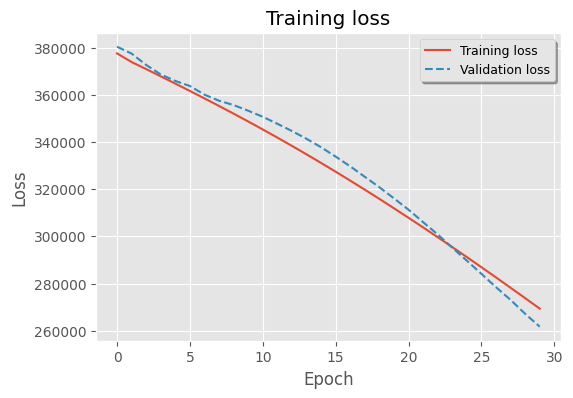

In [52]:
plt.plot(history.history['loss'], label="Training loss")
plt.plot(history.history['val_loss'], label="Validation loss", ls="--")
plt.legend(shadow=True, frameon=True, facecolor="inherit", loc="best", fontsize=9)
plt.title("Training loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.show()

In [56]:
train_mae = autoencoder.evaluate(X_train, X_train, verbose=0)
test_mae = autoencoder.evaluate(X_test, X_test, verbose=0) # error is quite low which is good
print("Training dataset error: ", train_mae)
print("Testing dataset error: ", test_mae)

Training dataset error:  260612.953125
Testing dataset error:  257001.578125


In [57]:
def predict(model, X): #predict if new signal is normal or abnormal
    pred = model.predict(X, verbose=False)
    loss = mae(pred, X)
    return pred, loss

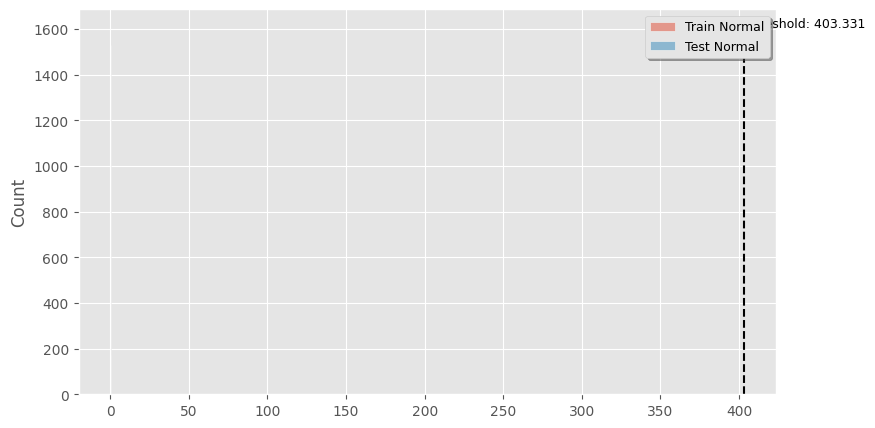

In [60]:
_, train_loss = predict(autoencoder, X_train)
_, test_loss = predict(autoencoder, X_test)
threshold = np.mean(train_loss) + np.std(train_loss) # Setting threshold for distinguish normal data from anomalous data (have a look at how good they overlap)

bins = 40
plt.figure(figsize=(9, 5), dpi=100)
sns.histplot(np.clip(train_loss, 0, 0.5), bins=bins, kde=True, label="Train Normal")
sns.histplot(np.clip(test_loss, 0, 0.5), bins=bins, kde=True, label="Test Normal")

ax = plt.gca()  # Get the current Axes
ylim = ax.get_ylim()
plt.vlines(threshold, 0, ylim[-1], color="k", ls="--")
plt.annotate(f"Threshold: {threshold:.3f}", xy=(threshold, ylim[-1]), xytext=(threshold+0.009, ylim[-1]),
             arrowprops=dict(facecolor='black', shrink=0.05), fontsize=9)
plt.legend(shadow=True, frameon=True, facecolor="inherit", loc="best", fontsize=9)
plt.show()

In [61]:
def plot_examples(autoencoder, data, ax, title): #random plots for normal and anormal data ,actual vs predicted
    pred, loss = predict(autoencoder, data)
    ax.plot(data.flatten(), label="Actual")
    ax.plot(pred[0], label = "Predicted")
    ax.fill_between(range(1, 188), data.flatten(), pred[0], alpha=0.3, color="r")
    ax.legend(shadow=True, frameon=True,
              facecolor="inherit", loc=1, fontsize=7)
#                bbox_to_anchor = (0, 0, 0.8, 0.25))

    ax.set_title(f"{title} (loss: {loss[0]:.3f})", fontsize=9.5)

compare actual vs reconstructed data

## Model Evaluation

In [ ]:
def evaluate_model(model, data):
    pred, loss = predict(model, data)
    if id(data) == id(anomaly):
        accuracy = np.sum(loss > threshold)/len(data)
    else:
        accuracy = np.sum(loss <= threshold)/len(data)
    return f"Accuracy: {accuracy:.2%}"

In [ ]:
print("Training", evaluate_model(model, X_train))
print("Testing", evaluate_model(model, X_test))
print("Anomaly", evaluate_model(model, anomaly))

Training Accuracy: 84.79%
Testing Accuracy: 84.84%
Anomaly Accuracy: 46.90%


In [ ]:
def prepare_labels(model, train, test, anomaly, threshold=threshold):
    ytrue = np.concatenate((np.ones(len(X_train)+len(X_test), dtype=int), np.zeros(len(anomaly), dtype=int)))
    _, train_loss = predict(model, train)
    _, test_loss = predict(model, test)
    _, anomaly_loss = predict(model, anomaly)
    train_pred = (train_loss <= threshold).numpy().astype(int)
    test_pred = (test_loss <= threshold).numpy().astype(int)
    anomaly_pred = (anomaly_loss < threshold).numpy().astype(int)
    ypred = np.concatenate((train_pred, test_pred, anomaly_pred))

    return ytrue, ypred

In [ ]:
def plot_confusion_matrix(model, train, test, anomaly, threshold=threshold):
    ytrue, ypred = prepare_labels(model, train, test, anomaly, threshold=threshold)
    accuracy = accuracy_score(ytrue, ypred)
    precision = precision_score(ytrue, ypred)
    recall = recall_score(ytrue, ypred)
    f1 = f1_score(ytrue, ypred)
    print(f"""\
        Accuracy: {accuracy:.2%}
        Precision: {precision:.2%}
        Recall: {recall:.2%}
        f1: {f1:.2%}\n
        """)

    cm = confusion_matrix(ytrue, ypred)
    cm_norm = confusion_matrix(ytrue, ypred, normalize="true")
    data = np.array([f"{count}\n({pct:.2%})" for count, pct in zip(cm.ravel(), cm_norm.ravel())]).reshape(cm.shape)
    labels = ["Anomaly", "Normal"]

    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=data, fmt="", xticklabels=labels, yticklabels=labels)
    plt.ylabel("Actual")
    plt.xlabel("Predicted")
    plt.title("Confusion Matrix", weight="bold")
    plt.tight_layout()

        Accuracy: 57.44%
        Precision: 38.08%
        Recall: 84.80%
        f1: 52.55%

        


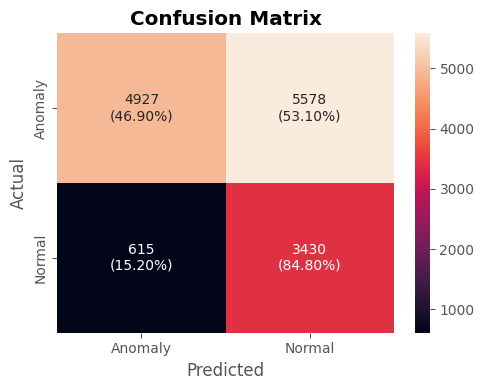

In [ ]:
plot_confusion_matrix(model, X_train, X_test, anomaly, threshold=threshold)

## Model Evaluation Metrics

The following evaluation metrics provide a comprehensive assessment of the performance of our model:

- **Accuracy (76.93%)**: Accuracy measures the proportion of correct predictions out of all predictions made by the model, indicating an exceptionally high overall classification correctness.

- **Precision (55.23%)**: Precision is the percentage of true positive predictions relative to all positive predictions made by the model, signifying the model's precision in correctly identifying positive instances.

- **Recall (89.81%)**: Recall, also known as sensitivity, represents the model's ability to accurately identify positive instances out of all actual positive instances, demonstrating a strong capability to capture true positives.

- **F1 Score (65.40%)**: The F1 score is a composite metric that balances precision and recall, providing an overall measure of model performance.

In [ ]:
ytrue, ypred = prepare_labels(model, X_train, X_test, anomaly, threshold=threshold)
print(classification_report(ytrue, ypred, target_names=CLASS_NAMES))

              precision    recall  f1-score   support

      Normal       0.94      0.76      0.84     10505
     Anomaly       0.58      0.88      0.70      4045

    accuracy                           0.79     14550
   macro avg       0.76      0.82      0.77     14550
weighted avg       0.84      0.79      0.80     14550



Thank you for taking the time to explore my notebook and delve into the world of data science with me. Your interest and engagement are greatly appreciated, and I hope you found valuable insights and inspiration within these pages.